# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque
from unityagents import UnityEnvironment
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


Import a general learning agent and create an instance with environment specific state and action information. The fixed seed parameter is used to make experiments comparable.  

In [5]:
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

The following code is used to train the learning agent. The initial criteria was to reach an avarage score of 13 or more for 100 consequtive games. At the current implementation the code runs until the end of all episodes, tries to reach the best result. For each best record it saves the environment to checkpoint-XX.pth where is XX is the integer part of the current high score, e.g. 18 when the score is 18.31.

In [6]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    max_score = 13
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    try:
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name] # reset the environment
            state = env_info.vector_observations[0]            # get the current state
            score = 0
            for t in range(max_t):
                action = agent.act(state, eps)

                env_info = env.step(action)[brain_name]        # send the action to the environment
                next_state = env_info.vector_observations[0]   # get the next state
                reward = env_info.rewards[0]                   # get the reward
                done = env_info.local_done[0]                  # see if episode has finished

                agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break 
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f} {:.4f}'.format(i_episode, np.mean(scores_window), eps))
            if np.mean(scores_window) >= max_score and len(scores_window) > 98:
                max_score = np.mean(scores_window)
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint-{}.pth'.format(int(np.floor(max_score))))
                if max_score >= 100:
                    break
    except Exception as e:
        print(type(e), e)
    finally:
        return scores

Run training.

Episode 100	Average Score: 0.00 0.7943
Episode 200	Average Score: 0.92 0.6309
Episode 300	Average Score: 1.82 0.5012
Episode 400	Average Score: 3.71 0.3981
Episode 500	Average Score: 5.24 0.3162
Episode 600	Average Score: 7.42 0.2512
Episode 700	Average Score: 8.39 0.1995
Episode 800	Average Score: 10.13 0.1585
Episode 900	Average Score: 11.33 0.1259
Episode 1000	Average Score: 12.42 0.1000
Episode 1053	Average Score: 13.03
Environment solved in 953 episodes!	Average Score: 13.03
Episode 1054	Average Score: 13.09
Environment solved in 954 episodes!	Average Score: 13.09
Episode 1055	Average Score: 13.12
Environment solved in 955 episodes!	Average Score: 13.12
Episode 1057	Average Score: 13.25
Environment solved in 957 episodes!	Average Score: 13.25
Episode 1058	Average Score: 13.28
Environment solved in 958 episodes!	Average Score: 13.28
Episode 1070	Average Score: 13.31
Environment solved in 970 episodes!	Average Score: 13.31
Episode 1071	Average Score: 13.31
Environment solved in 971 

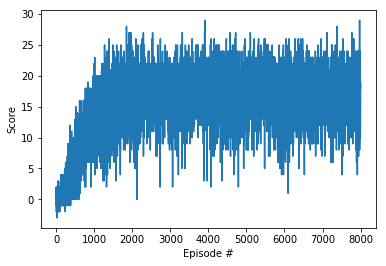

In [7]:
scores = dqn(n_episodes=8000, max_t=2000, eps_start=1, eps_decay=0.9977)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Close the unity environment

In [8]:
env.close()

Save scores to a json file, used to visualise learning progress.

In [9]:
import json

with open('scores.json', 'w') as fd:
    json.dump(scores, fd)